In [2]:
### NYCDSA Machine Learning Project
# Christopher Breuer
# August 11, 2021
# Predicting the sale price of houses from the Ames Housing data set
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import sklearn
from sklearn.feature_selection import chi2, f_regression, f_classif, mutual_info_classif,\
mutual_info_regression 
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold
FullData = pd.read_csv(r"./train.csv")
FullData

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
FullData["MasVnrType"]

0       BrkFace
1          None
2       BrkFace
3          None
4       BrkFace
         ...   
1455       None
1456      Stone
1457       None
1458       None
1459       None
Name: MasVnrType, Length: 1460, dtype: object

Text(0.5, 1.0, 'Sale Price Distribution')

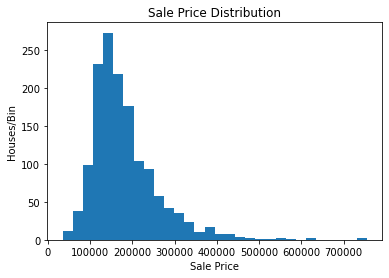

In [5]:
plt.hist(FullData["SalePrice"], bins=30)
plt.xlabel("Sale Price")
plt.ylabel("Houses/Bin")
plt.title("Sale Price Distribution")

In [6]:
# Convert SalePrice as it's not normally distributed
FullData["SPlog"] = np.log(FullData["SalePrice"])
FullData.drop(["SalePrice", "Alley"], inplace=True, axis=1)

In [7]:
#### Fixing classification data by changing rare data types to similar data types ###

# Throw out bad columns w/o much info and multiple N=1 groups
#ClassColumns.drop(["Condition2", "Heating", "HeatingQC"], inplace=True, axis=1)

# Replace values with low frequency with closely related but more common values to simplify the data
FullData['RoofStyle'] = FullData['RoofStyle'].replace(['Shed'],['Gable'])
FullData['Exterior1st'] = FullData['Exterior1st'].replace(["CBlock"],['CemntBd'])
FullData['Exterior1st'] = FullData['Exterior1st'].replace(["BrkComm"],['BrkFace'])
FullData['Exterior1st'] = FullData['Exterior1st'].replace(["AsphShn"],['AsbShng'])
FullData['Exterior1st'] = FullData['Exterior1st'].replace(["ImStucc"],['Stucco'])
FullData['RoofStyle'] = FullData['RoofStyle'].replace(["Shed"],['Gable'])
FullData['Exterior2nd'] = FullData['Exterior2nd'].replace(["CBlock"],['CmentBd'])
FullData['ExterCond'] = FullData['ExterCond'].replace(["Po"],['TA'])
FullData['RoofMatl'] = FullData['RoofMatl'].replace(["Metal", "Membran", "Roll"],['CompShg','CompShg','CompShg'])

In [8]:
### Identify columns with missing values
NA2 = pd.DataFrame(FullData.isna().any())
NA2["Feature"] = NA2.index
NA2.columns = ["Missing", "Feature"]
NA3 = NA2[NA2["Missing"] == True]
NA3.drop(["Missing"], axis=1)
Column = []
Missing = []
for colName in NA3["Feature"]:
    Column.append(colName)
    Missing.append(FullData[colName].isna().sum())
missingData = pd.DataFrame({"Column":Column, "Number Missing":Missing})
NA4 = missingData.sort_values(by="Number Missing", ascending=False)
out = r"./Missing.csv"
NA4.to_csv(out)
NA4

,Column,Number Missing
15,PoolQC,1453
17,MiscFeature,1406
16,Fence,1179
9,FireplaceQu,690
0,LotFrontage,259
10,GarageType,81
11,GarageYrBlt,81
12,GarageFinish,81
13,GarageQual,81
14,GarageCond,81


In [9]:
# Make a data frame for data imputation:
#   Method (Ordinal/Nominal Categorical): Most common value
#   Method (Numeric): median values by neighborhood

impDF = pd.DataFrame()
neighborhoodNames=FullData.groupby('Neighborhood')["Neighborhood"].unique().index
impDF["Neighborhood"] = neighborhoodNames
impDF.index=impDF["Neighborhood"]

In [10]:
# Manually divide numerical columns into quantitative and ordinal categorical for imputation
# Only a subset are missing totally at random
quantitativeCols = ["MasVnrArea", "LotFrontage"]
categoricalCols = ["MasVnrType", "Electrical"]

In [11]:
# Create Database for Nominal Categorical Imputation:
# Fill in database with the most common values by column per neighborhood

for CNAME in FullData.select_dtypes(object).columns:                     
    allNames = list(neighborhoodNames)
    DataAnalysis = pd.DataFrame(FullData.groupby('Neighborhood')[CNAME].value_counts())
    srt = DataAnalysis.index.sortlevel(level = 0, ascending = False)
    cat = {}
    for j in srt:
        for i in j:
            if isinstance(i,tuple):
                if i[0] not in cat.keys():
                    cat[i[0]] = i[1]
                else:
                    continue    
    if (len(cat.keys())) != 25:
        nnames = allNames
        for k in cat.keys():
            nnames.remove(k)
        for kk in nnames:
            cat[kk] = 0
    datacolumn = []
    for nbr in neighborhoodNames:
        datacolumn.append(cat[nbr])
    impDF[CNAME] = datacolumn

In [12]:
# Update Imputation Database with Numerical data values (mean/neighborhood)
# Calculate the median value for each neighborhood per column () 

for CNAME in FullData.select_dtypes(exclude=object).columns:                     
    allNames = list(neighborhoodNames)
    #print("### COLUMN ### =",  CNAME)
    DataAnalysis = pd.DataFrame(FullData.groupby('Neighborhood')[CNAME].mean())
    cat = {}
    for j in allNames:
        cat[j] = DataAnalysis.loc[j,CNAME]
    datacolumn = []
    for nbr in neighborhoodNames:
        datacolumn.append(cat[nbr])
    impDF[CNAME] = datacolumn
# Dataframe shouldn't have Neighborhood as a column, only as an index
impDF.drop(["Neighborhood"], axis=1, inplace=True)
print("Database of imputed values by neighborhood")
impDF

Database of imputed values by neighborhood


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SPlog
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Blmngtn,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,...,147.294118,15.529412,0.000000,0.000000,8.470588,0.000000,0.000000,5.705882,2007.470588,12.169416
Blueste,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,...,155.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.500000,11.826536
BrDale,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,...,68.250000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.812500,2007.687500,11.547864
BrkSide,RM,Pave,Reg,Lvl,AllPub,Inside,Mod,RRNn,RRNn,2fmCon,...,35.844828,25.344828,39.844828,2.482759,20.896552,0.000000,35.689655,6.206897,2007.672414,11.679727
ClearCr,RL,Pave,Reg,Lvl,AllPub,Inside,Sev,Norm,Norm,1Fam,...,188.821429,64.821429,32.535714,4.642857,34.928571,0.000000,32.142857,6.785714,2007.785714,12.239900
CollgCr,RM,Pave,Reg,Lvl,AllPub,Inside,Mod,PosN,Norm,TwnhsE,...,114.320000,51.720000,0.226667,2.593333,4.300000,0.000000,16.333333,6.140000,2007.806667,12.163641
Crawfor,RM,Pave,Reg,Lvl,AllPub,Inside,Mod,PosN,Norm,TwnhsE,...,52.568627,27.000000,46.176471,10.803922,30.176471,0.000000,49.019608,6.862745,2007.490196,12.206659
Edwards,RM,Pave,Reg,Lvl,AllPub,Inside,Sev,PosN,PosN,TwnhsE,...,70.770000,33.240000,26.380000,1.800000,15.250000,12.180000,16.000000,5.750000,2007.940000,11.712312
Gilbert,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,RRNn,Norm,2fmCon,...,102.822785,42.632911,0.000000,10.974684,3.683544,0.000000,21.265823,6.594937,2007.556962,12.155803


In [13]:
# Fix columns with missing values via imputation based on neighborhood patterns
impCols = ["MasVnrType", "Electrical", "MasVnrArea","LotFrontage"]
for c in impCols:
    print(c)
    indList = FullData[c].index[FullData[c].isna()]
    print("!!!: ", indList)
    for i in indList:
        val = FullData[c][i]
        nbr = FullData["Neighborhood"][i]
        rep = impDF.loc[nbr,c]
        #print("$$$: ",val, c,i,rep)
        FullData[c][i] = rep

MasVnrType
!!!:  Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
Electrical
!!!:  Int64Index([1379], dtype='int64')
MasVnrArea
!!!:  Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
LotFrontage
!!!:  Int64Index([   7,   12,   14,   16,   24,   31,   42,   43,   50,   64,
            ...
            1407, 1417, 1419, 1423, 1424, 1429, 1431, 1441, 1443, 1446],
           dtype='int64', length=259)


<ipython-input-13-528443bb3632>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullData[c][i] = rep


In [14]:
FullData

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SPlog
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072541
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254863
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864462


In [15]:
# Impute missing-not-at-random to category 0 
# Likely NA values are there because the house lacks that feature. Imputing to 0.

impCols2 = ["PoolQC", "MiscFeature", "Fence", "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual",
    "GarageCond", "BsmtExposure", "BsmtFinType2","BsmtFinType1","BsmtCond","BsmtQual"]

for c in impCols2:
    print(c)
    indList = FullData[c].index[FullData[c].isna()]
    print("!!!: ", indList)
    for i in indList:
        val = FullData[c][i]
        rep = 0
        FullData[c][i] = rep

PoolQC
!!!:  Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', length=1453)
MiscFeature
!!!:  Int64Index([   0,    1,    2,    3,    4,    6,    8,    9,   10,   11,
            ...
            1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1458, 1459],
           dtype='int64', length=1406)
Fence
!!!:  Int64Index([   0,    1,    2,    3,    4,    6,    7,    8,    9,   10,
            ...
            1447, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1458, 1459],
           dtype='int64', length=1179)


<ipython-input-15-ca28bd994ddd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullData[c][i] = rep


FireplaceQu
!!!:  Int64Index([   0,    5,   10,   12,   15,   17,   18,   19,   26,   29,
            ...
            1445, 1446, 1448, 1449, 1450, 1452, 1453, 1454, 1458, 1459],
           dtype='int64', length=690)
GarageType
!!!:  Int64Index([  39,   48,   78,   88,   89,   99,  108,  125,  127,  140,  148,
             155,  163,  165,  198,  210,  241,  250,  287,  291,  307,  375,
             386,  393,  431,  434,  441,  464,  495,  520,  528,  533,  535,
             562,  582,  613,  614,  620,  635,  636,  638,  649,  705,  710,
             738,  750,  784,  826,  843,  921,  942,  954,  960,  968,  970,
             976, 1009, 1011, 1030, 1038, 1096, 1123, 1131, 1137, 1143, 1173,
            1179, 1218, 1219, 1234, 1257, 1283, 1323, 1325, 1326, 1337, 1349,
            1407, 1449, 1450, 1453],
           dtype='int64')
GarageYrBlt
!!!:  Int64Index([  39,   48,   78,   88,   89,   99,  108,  125,  127,  140,  148,
             155,  163,  165,  198,  210,  241,  250,  287,  

In [16]:
# Confirmation: NaN Values successfully imputed for all data columns
# This is the original data column (example)
FullData.isna().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SPlog            False
Length: 80, dtype: bool

In [17]:
FullData

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SPlog
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,12.072541
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,0,0,2,2010,WD,Normal,12.254863
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2010,WD,Normal,11.864462


In [18]:
### Ordinal encoding of all categorical data

### Step 1: Ordinal data are created based upon the average SalePrice ###
# Dictionary of mini dictionaries:
#         column name: dictionary of values
#         e.g. 'Street': {'Grvl': 1, 'Pave': 2}

# Select all classification columns
ClassColumns = FullData.select_dtypes(object)
ClassColumns["SPlog"] = FullData["SPlog"]

OD = {}
for CNAME in ClassColumns.columns.drop(["SPlog"]):                      # Don't convert SalePrice column
    DataAnalysis = ClassColumns.groupby(CNAME)["SPlog"].median()          # Use SalePrice to order categorical data
    DataAnalysis.sort_values(inplace=True)
    DataDict = {}
    ctr = 0
    
    # Keep imputed value of 0 == 0
    DataDict["0"] = 0
    DataDict[0] = 0
    
    for i in DataAnalysis.index:
        ctr += 1
        DataDict[i] = ctr
    OD[CNAME] = DataDict
print("Number of Categorical Columns being converted: ", len(OD.keys()))

Number of Categorical Columns being converted:  42


<ipython-input-18-469dc60ae50b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClassColumns["SPlog"] = FullData["SPlog"]


In [19]:
## Final data frame. Start with numerical data columns only.
fullDF = FullData.select_dtypes(exclude=object)
print("Final data starts with ", len(fullDF.columns), "columns.")

Final data starts with  38 columns.


In [20]:
### Add categorical data to finalDF after ordinal encoding

# Encode 
convDF = pd.DataFrame() 
for col in OD.keys():
    conv_dict = OD[col]           # Specific dictionary for this column (categorical data entry:numerical)
    converted = []
    col_index = -1
    for value in ClassColumns[col]:
        col_index += 1 
        nbr = ClassColumns["Neighborhood"][col_index]
        converted.append(conv_dict[value])   # try to get value from dictionary
        
        # If there's no data for this particular row, impute the value based upon the Neighborhood
        #except KeyError:
        #    #converted.append(0)
        #    impValue = impDF.loc[nbr,col]
        #    converted.append(conv_dict[impValue])
    convDF[col] = pd.Series(converted)           # NaN is exception == class 0

# Make sure indices align -- KEY STEP or you can't add new data columns properly
convDF.index = fullDF.index

for cName in convDF:
    fullDF[cName] = convDF[cName]
    
###
# FROM HERE ON OUT: working with "fullDF"
# This has all categorical data converted to numerical (ordinal) data
###
print("Final data frame has with ", len(fullDF.columns), "columns.")

Final data frame has with  80 columns.


<ipython-input-20-184d501d538b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullDF[cName] = convDF[cName]


In [21]:
# Confirmation: Ordinal encoding of classification data
fullDF["Neighborhood"]

0       17
1       20
2       17
3       19
4       24
        ..
1455    14
1456    15
1457    19
1458    10
1459     5
Name: Neighborhood, Length: 1460, dtype: int64

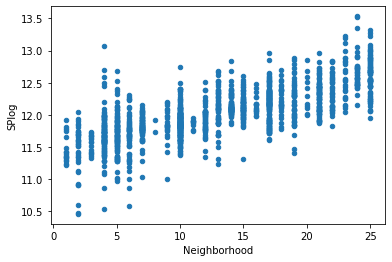

In [22]:
# Confirmation of ordinal encoding
# Should be a linear relationship with x-axis being numerical (neighborhood names)
fullDF.plot(kind='scatter', x="Neighborhood", y='SPlog')
plt.show()

In [23]:
# Remove Id column
fullDF.drop(["Id"], inplace=True, axis=1)

In [24]:
# Add HasPorch column
fullDF["totalPorchSF"] = fullDF['EnclosedPorch'] + fullDF['3SsnPorch'] + fullDF['ScreenPorch']

In [25]:
# Add total bathrooms column
fullDF["totalBathRms"] = fullDF['BsmtFullBath'] + fullDF['BsmtHalfBath']*0.5 + fullDF['FullBath'] + fullDF["HalfBath"]*0.5

In [26]:
############################################################################################
# At this point the full data frame is properly made and can be split into a train/test data set
#    - categorical/numerical NaNs were imputed to the mean (numerical), or class 0, categorical
#    - Categorical numbers are ordinal, meaning they correlate with saleprice
# Later processing:
# - Removal of non-useful columns from training and test data sets
# - Removal of outlier rows from training data set only
############################################################################################

In [27]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(fullDF.drop(["SPlog"],axis=1), fullDF["SPlog"], test_size=0.3)

# Need to remove outliers from Xtrain so I'm combining the data and target values for the training set again, just for now.
TrainingData = Xtrain
TrainingData["SPlog"] = Ytrain

In [28]:
# Remove outlier rows from training data set

# Remove all sales except "normal" sales (category #5, 184)
TrainingDataEdit = TrainingData[TrainingData["SaleCondition"] == 5]
TrainingDataEdit.drop(["SaleCondition"], axis=1, inplace = True)
Xtest.drop(["SaleCondition"], axis=1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
# Remove outlier rows from training data

# Distribution leans left, but has a long upper tail. Removing outliers.
TrainingDataEdit = TrainingDataEdit[TrainingDataEdit["GrLivArea"] < 3000]
#TrainingDataEdit = TrainingDataEdit[TrainingDataEdit["GrLivArea"] > 1000]

In [30]:
# Rebuild the training X and Y after outlier rows were removed
Xtrain = TrainingDataEdit.drop(["SPlog"], axis=1)
Ytrain = TrainingDataEdit["SPlog"]

In [31]:
# fit RF model on training set
rF = ensemble.RandomForestRegressor()
rF.set_params(random_state=599, oob_score=True, min_samples_leaf = 7, max_depth=30, n_estimators=500, min_samples_split=2)
firstModel = rF.fit(Xtrain, Ytrain) 
firstModel

RandomForestRegressor(max_depth=30, min_samples_leaf=7, n_estimators=500,
                      oob_score=True, random_state=599)

In [32]:
print("The train R2: %.5f" % (firstModel.score(Xtrain, Ytrain)))
print("The test R2: %.5f" % (firstModel.score(Xtest, Ytest)))
print()
print("The OOB score is: %.5f" % (firstModel.oob_score_))

The train R2: 0.93981
The test R2: 0.85222

The OOB score is: 0.87527


In [33]:
# Feature importance:
FI = pd.DataFrame({"Predictors":Xtrain.columns, "Importance":rF.feature_importances_})
FI.sort_values(by="Importance", ascending=False)
out = r"./FeatureImp.csv"
FI.to_csv(out)

In [34]:
rF.get_params(rF)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 599,
 'verbose': 0,
 'warm_start': False}

In [35]:
### Grid on fullDF2
# Borrowed code for this function!

# Set parameters for grid search
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Max levels per tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [4, 5, 6]

# Min samples per leaf node
min_samples_leaf = [3, 4, 5, 6]

# Use bootstrapping
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap, "oob_score" : "True" }

In [36]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# Borrowed code for this function!
rf_random = RandomizedSearchCV(estimator = rF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.9s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=30,
                                                   min_samples_leaf=7,
                                                   n_estimators=500,
                                                   oob_score=True,
                                                   random_state=599),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 12, 15, 17, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [3, 4, 5, 6],
                                        'min_samples_split': [4, 5, 6],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000],
                                        'oob_score': 'True'},
                   

In [37]:
# get the best parameters
rf_random.best_params_

{'oob_score': 'u',
 'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [88]:
rF.set_params(random_state=599, oob_score=True, min_samples_leaf = 4,
              max_depth=30, n_estimators=500, min_samples_split=5, max_features=20)
rF.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=30, max_features=20, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=500, oob_score=True,
                      random_state=599)

In [89]:
print("Best model R2 Train: %.5f" % (rF.score(Xtrain, Ytrain)))
print("Best Model R2 Test: %.5f" % (rF.score(Xtest, Ytest)))

Best model R2 Train: 0.95338
Best Model R2 Test: 0.85957


In [47]:
rf_random.feature_importances_

AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

In [39]:
# predictions converted back to actual dollar values
outData = pd.DataFrame({"Prediction":np.exp(rf_random.predict(Xtrain))})
outData

,Prediction
0,228685.594794
1,160198.145864
2,93069.426524
3,238947.434846
4,124568.055432
...,...
827,109891.241027
828,243171.737847
829,156009.122315
830,185148.632238


In [40]:
# Actual house values as dollars (not log transformed)
actuals = pd.DataFrame({"Actual":np.exp(Ytrain)})
actuals.index = outData.index
outData["Actual"] = actuals["Actual"]
outData["Model_Error"] = outData["Prediction"] - outData["Actual"]
outData

,Prediction,Actual,Model_Error
0,228685.594794,230000.0,-1314.405206
1,160198.145864,160000.0,198.145864
2,93069.426524,79500.0,13569.426524
3,238947.434846,228500.0,10447.434846
4,124568.055432,119500.0,5068.055432
...,...,...,...
827,109891.241027,94750.0,15141.241027
828,243171.737847,260000.0,-16828.262153
829,156009.122315,153000.0,3009.122315
830,185148.632238,188500.0,-3351.367762


In [41]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
outdataSRT = outData.sort_values(by="Actual")

# Low values
xvals = outData["Prediction"].values
yvals = outData["Model_Error"].values
linearModel = lm.fit(xvals.reshape(-1,1), yvals)

# Compensation values (y) vs. predicted house value (x)
Error_predLow = linearModel.predict(xvals.reshape(-1,1))
outData["CompensationLow"] = -Error_predLow

Text(0, 0.5, 'Error in $')

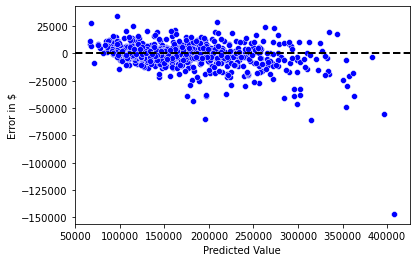

In [42]:
import seaborn as sns
sns.scatterplot(x=xvals,y=yvals,color="blue")
plt.axhline(y=0, xmin=0.0, xmax=700000, color='black', linestyle='--', linewidth=2)
plt.xlabel('Predicted Value')
plt.ylabel('Error in $') 

Text(0, 0.5, 'Error ($)')

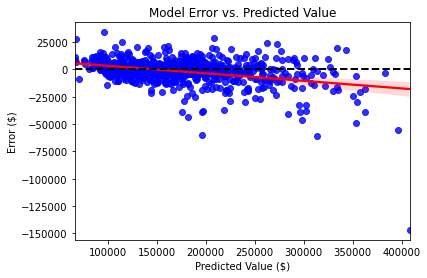

In [43]:
# Plot error with trend line
sns.regplot(x=xvals,y=yvals,fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.axhline(y=0, xmin=0.0, xmax=700000, color='black', linestyle='--', linewidth=2)
plt.xlabel('Predicted Value ($)')
plt.title("Model Error vs. Predicted Value")
plt.ylabel('Error ($)') 

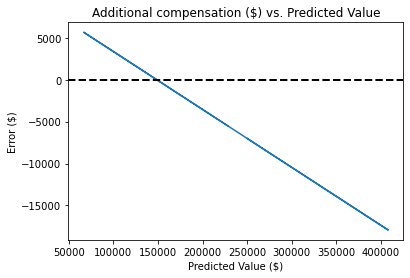

In [44]:
# Plot low model
plt.plot(xvals, Error_predLow)
plt.xlabel('Predicted Value ($)')
plt.title("Additional compensation ($) vs. Predicted Value")
plt.ylabel('Error ($)') 
plt.axhline(y=0, xmin=0.0, xmax=700000, color='black', linestyle='--', linewidth=2)

In [145]:
# High value compensation

xvalsHigh = outData["Prediction"][outData["Prediction"] > 320000].values
yvalsHigh = outData["Model_Error"][outData["Prediction"] > 320000].values
linearModelHigh = lm.fit(xvalsHigh.reshape(-1,1), yvalsHigh)
Error_predHigh = linearModelHigh.predict(xvals.reshape(-1,1))
outData["CompensationHigh"] = -Error_predHigh

In [146]:
# Adjust prediction for low values
outData["Adjusted_Pred"] = outData["Prediction"] + outData["CompensationLow"]

# Adjust prediction for high values
outData["Adjusted_Pred"][outData["Prediction"] > 380000] = outData["Prediction"] + outData["CompensationHigh"]

outData["Adj_Error"] = outData["Adjusted_Pred"] - outData["Actual"]
outData.sort_values(by="Actual", ascending=False)

,Prediction,Actual,Model_Error,CompensationLow,CompensationHigh,Adjusted_Pred,Adj_Error
11,411861.860586,555000.0,-143138.139414,17526.999735,56874.371551,468736.232137,-86263.767863
749,411914.904843,466500.0,-54585.095157,17530.569508,56909.018741,468823.923584,2323.923584
3,390424.910850,451950.0,-61525.089150,16084.335589,42872.288841,433297.199692,-18652.800308
14,345550.648647,403000.0,-57449.351353,13064.386858,13561.536209,358615.035505,-44384.964495
579,411428.210239,386250.0,25178.210239,17497.815927,56591.121923,468019.332162,81769.332162
...,...,...,...,...,...,...,...
188,61019.724365,60000.0,1019.724365,-6083.979300,-172286.990956,54935.745065,-5064.254935
158,65477.310480,58500.0,6977.310480,-5783.992607,-169375.406508,59693.317873,1193.317873
109,69040.816450,55000.0,14040.816450,-5544.175732,-167047.812986,63496.640718,8496.640718
602,66398.725909,52500.0,13898.725909,-5721.983178,-168773.560853,60676.742731,8176.742731


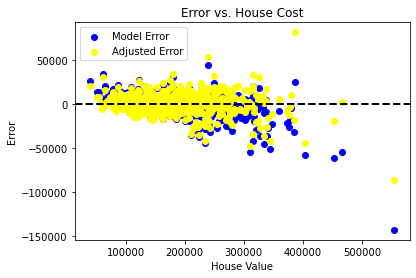

In [147]:
plt.scatter(outData["Actual"], outData["Model_Error"], c = 'blue', label='Model Error')
plt.scatter(outData["Actual"], outData["Adj_Error"], c = 'yellow', label='Adjusted Error')
plt.legend(loc=2)
plt.xlabel('House Value')
plt.ylabel('Error')
plt.title('Error vs. House Cost')
plt.axhline(y=0, xmin=0.0, xmax=700000, color='black', linestyle='--', linewidth=2)
plt.show()

Text(0, 0.5, 'Model Error ($)')

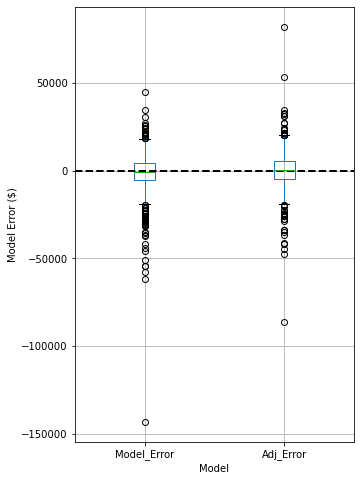

In [148]:
# Plotting adjusted error
outData.boxplot(column=['Model_Error', 'Adj_Error'], figsize=(5,8), grid=True)
plt.axhline(y=0, xmin=0.0, xmax=700000, color='black', linestyle='--', linewidth=2)
plt.xlabel('Model')
plt.ylabel('Model Error ($)') 
                                                                 

In [149]:
def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 
pre = outData["Prediction"].values
adj = outData["Adjusted_Pred"].values
act = outData["Actual"]
print("RMSE Model (Training): ", np.sqrt(mse(act, pre)))
print("RMSE Adjusted Model (Training): ", np.sqrt(mse(act, adj)))

RMSE Model (Training):  11526.84406317243
RMSE Adjusted Model (Training):  10346.434461696721


In [150]:
outData

,Prediction,Actual,Model_Error,CompensationLow,CompensationHigh,Adjusted_Pred,Adj_Error
0,118597.240835,124000.0,-5402.759165,-2209.126784,-134678.788401,116388.114051,-7611.885949
1,146507.931892,148000.0,-1492.068108,-330.792703,-116448.218777,146177.139189,-1822.860811
2,218702.457644,211000.0,7702.457644,4527.755509,-69292.549093,223230.213154,12230.213154
3,390424.910850,451950.0,-61525.089150,16084.335589,42872.288841,433297.199692,-18652.800308
4,174616.480280,177500.0,-2883.519720,1560.856783,-98088.413664,176177.337063,-1322.662937
...,...,...,...,...,...,...,...
831,248033.738572,260400.0,-12366.261428,6501.692467,-50134.085478,254535.431039,-5864.568961
832,132553.463979,133900.0,-1346.536021,-1269.900682,-125562.930352,131283.563297,-2616.436703
833,85520.349331,82500.0,3020.349331,-4435.135895,-156283.791740,81085.213435,-1414.786565
834,129967.712235,130250.0,-282.287765,-1443.916639,-127251.879117,128523.795596,-1726.204404


In [151]:
# R2
ma = np.mean(outData["Actual"])
TSS = sum((outData["Actual"] - ma)**2)
RSS1 = sum((outData["Model_Error"])**2)
RSS2 = sum((outData["Adj_Error"])**2)
R2_model = 1-(RSS1/TSS)
R2_adj = 1-(RSS2/TSS)
print("Model R2 (Training): ", R2_model)
print("Adjusted Model R2 (Training): ", R2_adj)

Model R2 (Training):  0.9676026708229428
Adjusted Model R2 (Training):  0.9738982398363927


In [152]:
# Apply base model to test data
rf_random.predict(Xtest)
rf_random.score(Xtest, Ytest)

0.8872412808919232

In [153]:
# Apply model to test data
testVals = pd.DataFrame({"Prediction":np.exp(rf_random.predict(Xtest))})

# Add in actuals
Ytest.index = testVals.index         #index matching
testVals["Actual"] = np.exp(Ytest)
testVals

,Prediction,Actual
0,273648.766706,290000.0
1,150594.338021,162000.0
2,177944.778418,149000.0
3,158543.349051,146500.0
4,419550.885962,755000.0
...,...,...
433,136356.901724,139500.0
434,175666.065709,172000.0
435,142983.717062,120000.0
436,199362.288338,195000.0


In [154]:
# Calculate correction amount
pred_values = (testVals["Prediction"].values).reshape(-1,1)
linearModel = lm.fit(xvals.reshape(-1,1), yvals)  # Train the model on the training data
corrected = linearModel.predict(pred_values)
testVals["CompensationLow"] = - corrected

In [155]:
# High value correction values
xvalsHigh.reshape(-1,1)
linearModelHigh = lm.fit(xvalsHigh.reshape(-1,1), yvalsHigh)
corrected_high = linearModelHigh.predict(pred_values)
corrected_high
testVals["CompensationHigh"] = - corrected_high
testVals

,Prediction,Actual,CompensationLow,CompensationHigh
0,273648.766706,290000.0,8225.532992,-33402.985813
1,150594.338021,162000.0,-55.785686,-113779.079870
2,177944.778418,149000.0,1784.844638,-95914.452051
3,158543.349051,146500.0,479.166970,-108586.983453
4,419550.885962,755000.0,18044.455873,61896.651800
...,...,...,...,...
433,136356.901724,139500.0,-1013.936875,-123078.619359
434,175666.065709,172000.0,1631.491798,-97402.850551
435,142983.717062,120000.0,-567.965363,-118750.148303
436,199362.288338,195000.0,3226.200522,-81925.066946


In [156]:
# Create corrected predictions

# Adjust prediction for low values
testVals["Adjusted_Pred"] = testVals["Prediction"]

## Adjust prediction for high values
testVals["Adjusted_Pred"][testVals["Prediction"] > 380000] = testVals["Prediction"] + testVals["CompensationHigh"]

# Model Error vs. Adjusted Error
testVals["Adj_Error"] = testVals["Adjusted_Pred"] - testVals["Actual"]
testVals["Model_Error"] = testVals["Prediction"] - testVals["Actual"]
testVals.sort_values(by="Actual", ascending=False)
testVals

,Prediction,Actual,CompensationLow,CompensationHigh,Adjusted_Pred,Adj_Error,Model_Error
0,273648.766706,290000.0,8225.532992,-33402.985813,273648.766706,-16351.233294,-16351.233294
1,150594.338021,162000.0,-55.785686,-113779.079870,150594.338021,-11405.661979,-11405.661979
2,177944.778418,149000.0,1784.844638,-95914.452051,177944.778418,28944.778418,28944.778418
3,158543.349051,146500.0,479.166970,-108586.983453,158543.349051,12043.349051,12043.349051
4,419550.885962,755000.0,18044.455873,61896.651800,481447.537762,-273552.462238,-335449.114038
...,...,...,...,...,...,...,...
433,136356.901724,139500.0,-1013.936875,-123078.619359,136356.901724,-3143.098276,-3143.098276
434,175666.065709,172000.0,1631.491798,-97402.850551,175666.065709,3666.065709,3666.065709
435,142983.717062,120000.0,-567.965363,-118750.148303,142983.717062,22983.717062,22983.717062
436,199362.288338,195000.0,3226.200522,-81925.066946,199362.288338,4362.288338,4362.288338


In [157]:
# Calculate MSE:
pre = testVals["Prediction"].values
adj = testVals["Adjusted_Pred"].values
act = testVals["Actual"]
print("RMSE Model (Training): ", np.sqrt(mse(act, pre)))
print("RMSE Adjusted Model (Training): ", np.sqrt(mse(act, adj)))

RMSE Model (Training):  35317.43777019915
RMSE Adjusted Model (Training):  33266.12896350673


In [158]:
# R2
ma = np.mean(testVals["Actual"])
TSS = sum((testVals["Actual"] - ma)**2)
RSS1 = sum((testVals["Model_Error"])**2)
RSS2 = sum((testVals["Adj_Error"])**2)
R2_model = 1-(RSS1/TSS)
R2_adj = 1-(RSS2/TSS)
print("Model R2 (test): ", R2_model)
print("Adjusted Model R2 (test): ", R2_adj)

Model R2 (test):  0.8329968136177047
Adjusted Model R2 (test):  0.8518331957319351


In [177]:
###################
# Get kaggle test data
##################
kd = pd.read_csv(r"./test.csv")
kd

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [160]:
# Convert SalePrice as it's not normally distributed
kd.drop(["Alley"], inplace=True, axis=1)
kd['RoofStyle'] = kd['RoofStyle'].replace(['Shed'],['Gable'])
kd['Exterior1st'] = kd['Exterior1st'].replace(["CBlock"],['CemntBd'])
kd['Exterior1st'] = kd['Exterior1st'].replace(["BrkComm"],['BrkFace'])
kd['Exterior1st'] = kd['Exterior1st'].replace(["AsphShn"],['AsbShng'])
kd['Exterior1st'] = kd['Exterior1st'].replace(["ImStucc"],['Stucco'])
kd['RoofStyle'] = kd['RoofStyle'].replace(["Shed"],['Gable'])
kd['Exterior2nd'] = kd['Exterior2nd'].replace(["CBlock"],['CmentBd'])
kd['ExterCond'] = kd['ExterCond'].replace(["Po"],['TA'])
kd['RoofMatl'] = kd['RoofMatl'].replace(["Metal", "Membran", "Roll"],['CompShg','CompShg','CompShg'])
print("Checking on Imputation pre for GarageType (note: 'Nan'):", kd["GarageType"].unique())

Checking on Imputation pre for GarageType (note: 'Nan'): ['Attchd' 'Detchd' 'BuiltIn' nan 'Basment' '2Types' 'CarPort']


In [161]:
# Identifying columns with missing values
m = kd.isna().any()
missingCols = m[m].index
print("Total columns with missing values: ", len(missingCols))

Total columns with missing values:  32


In [162]:
# Impute missing-not-at-random to category 0 

impCols2 = ["PoolQC", "MiscFeature", "Fence", "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual",
    "GarageCond", "BsmtExposure", "BsmtFinType2","BsmtFinType1","BsmtCond","BsmtQual"]

for c in impCols2:
    indList = kd[c].index[kd[c].isna()]
    for i in indList:
        val = kd[c][i]
        rep = 0
        kd[c][i] = rep

<ipython-input-162-7e0dcc4e86ab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kd[c][i] = rep


In [163]:
# Missing values
#missing = pd.DataFrame()
m = kd.isna().any()
missingCols = m[m].index
print("Total columns with missing values: ", len(missingCols))
missingCols

Total columns with missing values:  18


Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageCars', 'GarageArea', 'SaleType'],
      dtype='object')

In [164]:
# Fix columns with missing values via imputation based on neighborhood patterns
for c in missingCols:
    indList = kd[c].index[kd[c].isna()]
    for i in indList:
        val = kd[c][i]
        nbr = kd["Neighborhood"][i]
        rep = impDF.loc[nbr,c]
        kd[c][i] = rep

<ipython-input-164-571415a0189c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kd[c][i] = rep


In [165]:
# Missing values
#missing = pd.DataFrame()
m = kd.isna().any()
missingCols = m[m].index
print("Total columns with missing values: ", len(missingCols))

Total columns with missing values:  0


In [166]:
finalTDF = pd.DataFrame(kd.select_dtypes(exclude=object))

# Ordinal Encoding based on training data (neighborhood)
ClassColumns = kd.select_dtypes(object).columns

# Encode
convDF = pd.DataFrame() 
for col in OD.keys():
    conv_dict = OD[col]           # Specific dictionary for this column (categorical data entry:numerical)
    converted = []
    col_index = -1
    for value in kd[col]:
        col_index += 1 
        nbr = kd["Neighborhood"][col_index]
        converted.append(conv_dict[value])   # try to get value from dictionary
        
        # If there's no data for this particular row, impute the value based upon the Neighborhood
        #except KeyError:
        #    #converted.append(0)
        #    impValue = impDF.loc[nbr,col]
        #    converted.append(conv_dict[impValue])
    convDF[col] = pd.Series(converted)           # NaN is exception == class 0

# Make sure indices align -- KEY STEP or you can't add new data columns properly
convDF.index = finalTDF.index

for cName in convDF:
    finalTDF[cName] = convDF[cName]
    
###
# FROM HERE ON OUT: working with "finalTDF"
# This has all categorical data converted to numerical (ordinal) data
###
print("Final data frame has with ", len(fullDF.columns), "columns.")

Final data frame has with  81 columns.


In [167]:
finalTDF

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,6,2,5,6,3,1,2,3,6,5
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,6,2,5,6,3,1,5,4,6,5
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,6,4,5,6,3,1,2,3,6,5
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,6,4,5,6,3,1,5,3,6,5
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,6,3,5,6,3,1,5,3,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,1,1,2,1,3,1,5,3,6,5
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,2,2,5,6,3,1,5,3,6,2
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,3,2,5,6,3,1,5,3,6,2
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,1,1,2,1,3,1,2,2,6,5


In [168]:
# Predict
pre_values = rf_random.predict(finalTDF)

In [178]:
# Data Frame of predicted values for the Kaggle test data
tv
outPred1 = "./OutPredictions.csv"
tv.to_csv(outPred1)